# M5 Forecasting Competition - Accuracy
## Step 2. Basics of Time Series Data

This workbook will begin a top down approach by aggregating the sales data at the state level and demonstrating some basic principles of time series forecasting.

### 1. Load and Group Data

In a previous workbook, I transformed the datasets provided by the competition into a tall format and merged the sales volumes with the calendar and price data. For this workbook I will be using a simplified and reduced version of the time series data that includes only the sales volume aggregated at the state level.

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sales = './data/sales_train_evaluation.gz'
calendar = './data/calendar.gz'
sell_prices = './data/sell_prices.gz'

sales = pd.read_csv(sales, index_col = 0, compression = 'gzip')
calendar =  pd.read_csv(calendar, index_col = 0, compression = 'gzip')
sell_prices =  pd.read_csv(sell_prices, index_col = 0, compression = 'gzip')

drop_ids = ['id', 'item_id', 'dept_id','cat_id','store_id'] # drop id features other than state
sales.drop(drop_ids, axis = 1, inplace=True)

sales.head()

,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA,0,0,0,0,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,CA,0,0,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,CA,0,0,0,0,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,CA,0,0,0,0,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,CA,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


The following code melts the dataframe to convert to a tall format then performs a left join with the calendar data.

In [2]:
ids = ['state_id']
sales = pd.melt(sales, id_vars=ids, var_name = 'd', value_name = 'units') 

# subset of calendar features to keep for the model
cal = ['d', 'date', 'weekday','event_type_1', 'event_type_2', 'snap_CA', 'snap_WI', 'snap_TX']
sales_calendar = pd.merge(sales, calendar[cal], how = 'left', on = 'd')
# drop feature d since we now can index to datetime 
sales_calendar.drop('d', axis = 1, inplace = True)

del sales
del calendar

In [5]:
sales_calendar.shape

(59181090, 9)

In [6]:
sales_calendar.head()

,state_id,units,date,weekday,event_type_1,event_type_2,snap_CA,snap_WI,snap_TX
0,CA,0,2011-01-29,Saturday,NaN,NaN,0,0,0
1,CA,0,2011-01-29,Saturday,NaN,NaN,0,0,0
2,CA,0,2011-01-29,Saturday,NaN,NaN,0,0,0
3,CA,0,2011-01-29,Saturday,NaN,NaN,0,0,0
4,CA,0,2011-01-29,Saturday,NaN,NaN,0,0,0


The following step aggregates the data by state and date using the **groupby** method. 

In [9]:
# need to fill NAs before grouping  
sales_calendar.fillna('none', inplace = True)

# features to keep in grouped df
features = ['state_id', 'date', 'weekday', 'event_type_1', 'event_type_2', 'snap_CA', 'snap_WI', 'snap_TX']
state = sales_calendar.groupby(features)['units'].sum().reset_index()
state.head()

,state_id,date,weekday,event_type_1,event_type_2,snap_CA,snap_WI,snap_TX,units
0,CA,2011-01-29,Saturday,none,none,0,0,0,14195
1,CA,2011-01-30,Sunday,none,none,0,0,0,13805
2,CA,2011-01-31,Monday,none,none,0,0,0,10108
3,CA,2011-02-01,Tuesday,none,none,1,0,1,11047
4,CA,2011-02-02,Wednesday,none,none,1,1,0,9925


For the following analysis, the data needs to be converted to time series in which the date has been cast as datetime and functions as the index.

### 2. ARIMA model

Time series data involves a value (y) that is recorded over a regular time interval (days in our case). Unlike a a typical machine learning problem, pure time series data does not have a set of features (x) on which to base a model. Instead, forecasting models must use a previous value of y (the lag) to predict the current value.

For the sample analysis I will use the data for CA. The first step in the analysis is to transform the pandas dataframe into a proper timeseries with the date as the index.

In [10]:
ca = state[['date', 'units']].loc[state['state_id'] == 'CA']
ca['date'] = pd.to_datetime(ca['date'])
ca = ca.set_index('date')

ca.head()

,units
date,
2011-01-29,14195
2011-01-30,13805
2011-01-31,10108
2011-02-01,11047
2011-02-02,9925


The aggregate sales data for CA is shown in the following plot. (Note that the days with 0 sales are Christmas, December 25). 

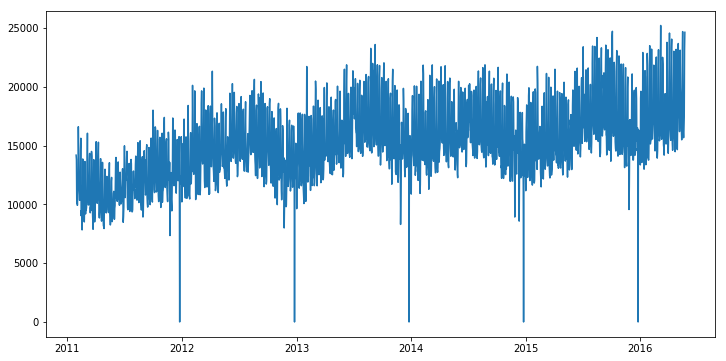

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(ca)

The next step is to split the data into train and test sets. The train set will end 04-24-2016 and the test set will be defined as the final 28 days, beginning on 04-25-2016. Note that when dealing with time series data, the train and test sets should **not** be split randomly or the trend will be lost.

In [12]:
ca_train = ca[:-28]
ca_test = ca[-28:]

In [55]:
ca_train.tail()

,units
date,
2016-04-20,15148
2016-04-21,14488
2016-04-22,17095
2016-04-23,21834
2016-04-24,23187


In [56]:
ca_test.head()

,units
date,
2016-04-25,17524
2016-04-26,15012
2016-04-27,14836
2016-04-28,14664
2016-04-29,17180


One popular approach to time series forecasting is to use an Auto Regressive Integrated Moving Average (ARIMA). This approach builds a linear regression model by moving through the time series using the lags to predict the current value and the lag errors to adjust the model. 

The statsmodels tsa package includes a **SARIMAX** class that can be used to implement an ARIMA model. The ARIMA model requires 3 parameters: you must specify the order of terms p, d, and q. (Note that I used a Grid Search approach elsewhere to optimize these parameters). 

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima = SARIMAX(ca_train, 
                order = (5,1,5), 
                seasonal_order = (0,0,0,0)) # These parameters are used for a SARIMA model, set to 0 here
arima_fit = arima.fit()

/Users/peterbekins/opt/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/peterbekins/opt/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Models can be compared based on the AIC value (lower is better).

In [40]:
arima_fit.aic

33255.436987619585

In [96]:
arima_pred = arima_fit.predict(start = 1, end = len(ca_train)+27)

The following plot shows both the original sales data for CA and the sales volume predicted by the ARIMA model for the 28 days of the test set.

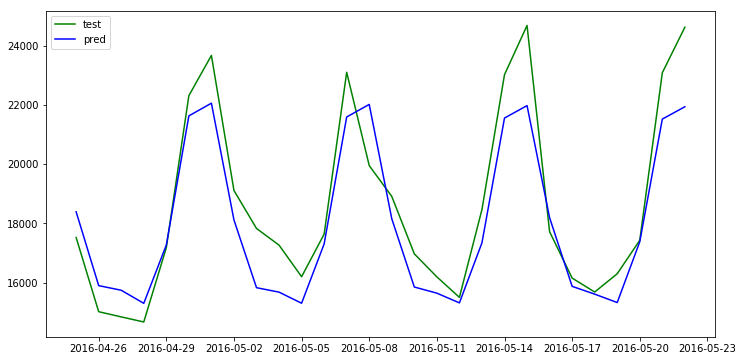

In [107]:
plt.figure(figsize=(12, 6))
plt.plot(ca_test, c='green', label = 'test')
plt.plot(arima_pred[-28:], c='blue', label = 'pred')
plt.legend(loc="upper left")

The accuracy of the model can be evaluated using the **mean squared error** method provided by scikit learn.

In [98]:
from sklearn.metrics import mean_squared_error
real = ca_test['units'].values
a_pred = arima_pred[-28:].values
mse = mean_squared_error(real, a_pred)
print mse

1600990.7787894716


### 3. SARIMA model

If time series data has a seasonal component, it is more appropriate to use a SARIMA model (S = Seasonal). This model includes four extra parameters to specify the order of the seasonal terms P, D, and Q, as well as the number of periods in a season, S. Let's take a second look at the plot for the aggregate sales data for CA.

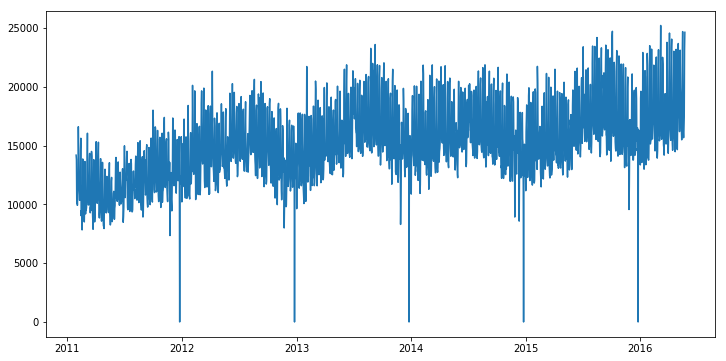

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(ca)

You will notice a seasonal trend in which sales gradually increase over the first three quarters of the year but fall during the fourth quarter. For this reason, I will set S=4 in order to indicate that the seasonal period is quarterly. 

In [44]:
sarima = SARIMAX(ca_train, 
                order = (5,1,5), 
                seasonal_order = (1,1,1,4))
sarima_fit = sarima.fit()

/Users/peterbekins/opt/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/peterbekins/opt/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC score is again used to compare models.

In [46]:
sarima_fit.aic

33956.668338996256

In [93]:
sarima_pred = sarima_fit.predict(start = 1, end = len(ca_train)+27)

The following plot shows both the original sales data for CA and the sales volume predicted by the SARIMA model for the 28 days of the test set.

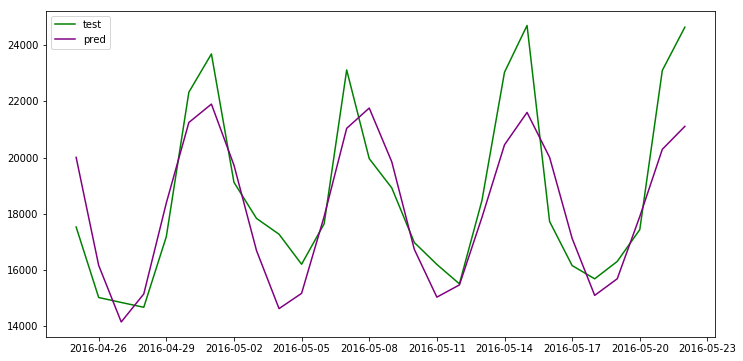

In [106]:
plt.figure(figsize=(12, 6))
plt.plot(ca_test, c='green', label = 'test')
plt.plot(sarima_pred[-28:], c='purple', label = 'pred')
plt.legend(loc="upper left")

Once again, we can evaluate the accuracy of the model using mean squared error. 

In [95]:
real = ca_test['units'].values
s_pred = sarima_pred[-28:].values
mse = mean_squared_error(real, s_pred)
print mse

2779424.1075744596


Unexpectedly, the SARIMA model actually has a has a higher  MSE (~2.8M) than the ARIMA model (~1.6M).

### 4. Adding Features

For this forecasting project, we are not limited to pure time series data. For instance, the calendar data also provides information about the day of the week, special events, and SNAP days that we can use in our model. The SARIMAX package allows us to include these features as **exogenous** variables (note that the time series values are termed the **endogenous** variable).  

We will create the exogenous variables by selecting the relevant columns from the **state** dataframe created above. Nesxt, ee will use the **get_dummies** method to apply one-hot encoding to these categorical features. Finally, the date must also be set as the index in order to match the time series data used as the endogenous variable.

In [82]:
ca_x = state[['date','weekday', 'event_type_1', 'event_type_2', 'snap_CA']].loc[state['state_id'] == 'CA']
ca_x = pd.get_dummies(ca_x, columns=['weekday', 'event_type_1', 'event_type_2', 'snap_CA'])

# drop unused features
drop_cols = ['event_type_1_none', 'event_type_1_none', 'snap_CA_0']
ca_x.drop(drop_cols, axis = 1, inplace = True)

# set cast date as datetime and set as index
ca_x['date'] = pd.to_datetime(ca_x['date'])
ca_x = ca_x.set_index('date')

ca_x.head()

,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,event_type_2_none,snap_CA_1
date,,,,,,,,,,,,,,,
2011-01-29,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2011-01-30,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2011-01-31,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2011-02-01,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
2011-02-02,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1


In [83]:
ca_x_train = ca_x[:-28]
ca_x_test = ca_x[-28:]

In [84]:
ca_x_train.tail()

,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,event_type_2_none,snap_CA_1
date,,,,,,,,,,,,,,,
2016-04-20,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2016-04-21,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2016-04-22,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2016-04-23,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2016-04-24,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [85]:
ca_x_test.head()

,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,event_type_2_none,snap_CA_1
date,,,,,,,,,,,,,,,
2016-04-25,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2016-04-26,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2016-04-27,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2016-04-28,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2016-04-29,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


We will use an ARIMAX model since the ARIMA model was more accurate than the SARIMA model. The exogenous data is incorporated into the model below.

In [99]:
arimax = SARIMAX(endog = ca_train, 
                  exog = ca_x_train,
                  order = (5,1,5), 
                  seasonal_order = (0,0,0,0))
arimax_fit = arimax.fit()

/Users/peterbekins/opt/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/peterbekins/opt/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


We can again check the AIC score for the model.

In [100]:
arimax_fit.aic

33185.69875610224

Note that exogenous variables for the prediction period must also be used in the predict method, with the feature rows matching the days to be predicted.

In [103]:
arimax_pred = arimax_fit.predict(start = 1, end = len(ca_train)+27, exog = ca_x_test)

The following plot shows both the original sales data for CA and the sales volume predicted by the ARIMAX model with exogoneous data for the 28 days of the test set.

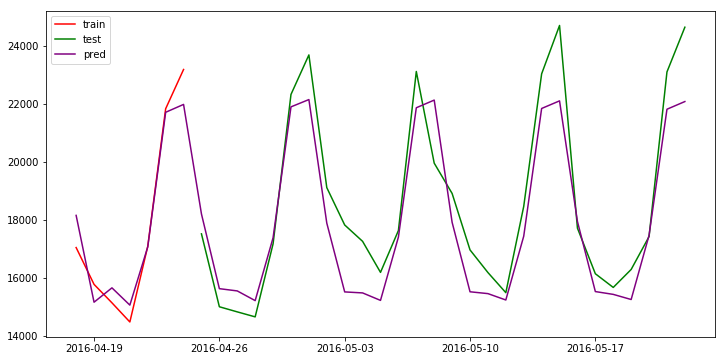

In [104]:
plt.figure(figsize=(12, 6))
plt.plot(ca_train[-7:], c='red', label = 'train')
plt.plot(ca_test, c='green', label = 'test')
plt.plot(sarimax_pred[-35:], c='purple', label = 'pred')
plt.legend(loc="upper left")

In [105]:
real = ca_test['units'].values
sx_pred = sarimax_pred[-28:].values
mse = mean_squared_error(real, sx_pred)
print mse

1577983.6685261014


The MSE for the ARIMAX model (~1.57M) is indeed slightly lower than the ARIMA model (~1.60M).